In [1]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 6.3 MB/s eta 0:00:00a 0:00:01


In [ ]:
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image as image_loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import tensorflow as tf

Define hyper parameter

In [5]:
Image_Width = 224
Image_Height = 224
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3



Batch_Size = 40
lr=1e-2
loss_function = "categorical_crossentropy"
Epochs = 10

Define Paths

In [6]:
#main_path = "datasets/misc/lspd/images/aliakbar"
main_path = "/tf/dataset/cavity_images"
#train_path = main_path + "/train"
#test_path = main_path + "/test"
#validation_path = main_path + "/validation"
checkpoint_filepath = "check_point.h5"
tensorboard_log = "logs"
model_save_path = "."

Dataset Preparation

In [70]:
main_datagen = ImageDataGenerator(
    rotation_range=10, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.2,1.2],
    validation_split=0.2,
) 

train_generator = main_datagen.flow_from_directory(
    directory=main_path,
    target_size=Image_Size,
    subset="training",
    class_mode='categorical',
    color_mode="rgb",
    batch_size=Batch_Size,
    shuffle=True,
    seed=2020 # to make the result reproduciblec
)
test_generator = main_datagen.flow_from_directory(
    directory=main_path,
    target_size=Image_Size,
    subset="validation",
    class_mode='categorical',
    color_mode="rgb",
    batch_size=Batch_Size,
    shuffle=True,
    seed=2020 # to make the result reproduciblec
)
Num_Class=train_generator.num_classes
#class_names =  train_generator.class_names
sample = next(train_generator)
print(sample[0].shape)


Found 16059 images belonging to 10 classes.
Found 4008 images belonging to 10 classes.
(40, 260, 260, 3)
(40, 260, 260, 3)


In [63]:
for sample in train_generator:
    image = sample[0].astype('uint8')
    print(image)
    break


[[[[115 115 115]
   [115 115 115]
   [115 115 115]
   ...
   [112 112 112]
   [113 113 113]
   [112 112 112]]

  [[115 115 115]
   [115 115 115]
   [115 115 115]
   ...
   [113 113 113]
   [113 113 113]
   [112 112 112]]

  [[115 115 115]
   [115 115 115]
   [115 115 115]
   ...
   [113 113 113]
   [113 113 113]
   [112 112 112]]

  ...

  [[117 117 117]
   [117 117 117]
   [116 116 116]
   ...
   [109 109 109]
   [109 109 109]
   [110 110 110]]

  [[117 117 117]
   [117 117 117]
   [117 117 117]
   ...
   [109 109 109]
   [109 109 109]
   [110 110 110]]

  [[116 116 116]
   [116 116 116]
   [116 116 116]
   ...
   [110 110 110]
   [110 110 110]
   [109 109 109]]]


 [[[ 93  93  93]
   [ 92  92  92]
   [ 92  92  92]
   ...
   [ 94  94  94]
   [ 94  94  94]
   [ 94  94  94]]

  [[ 93  93  93]
   [ 92  92  92]
   [ 92  92  92]
   ...
   [ 94  94  94]
   [ 94  94  94]
   [ 94  94  94]]

  [[ 93  93  93]
   [ 92  92  92]
   [ 92  92  92]
   ...
   [ 94  94  94]
   [ 94  94  94]
   [ 94  94

Plot somr Datas

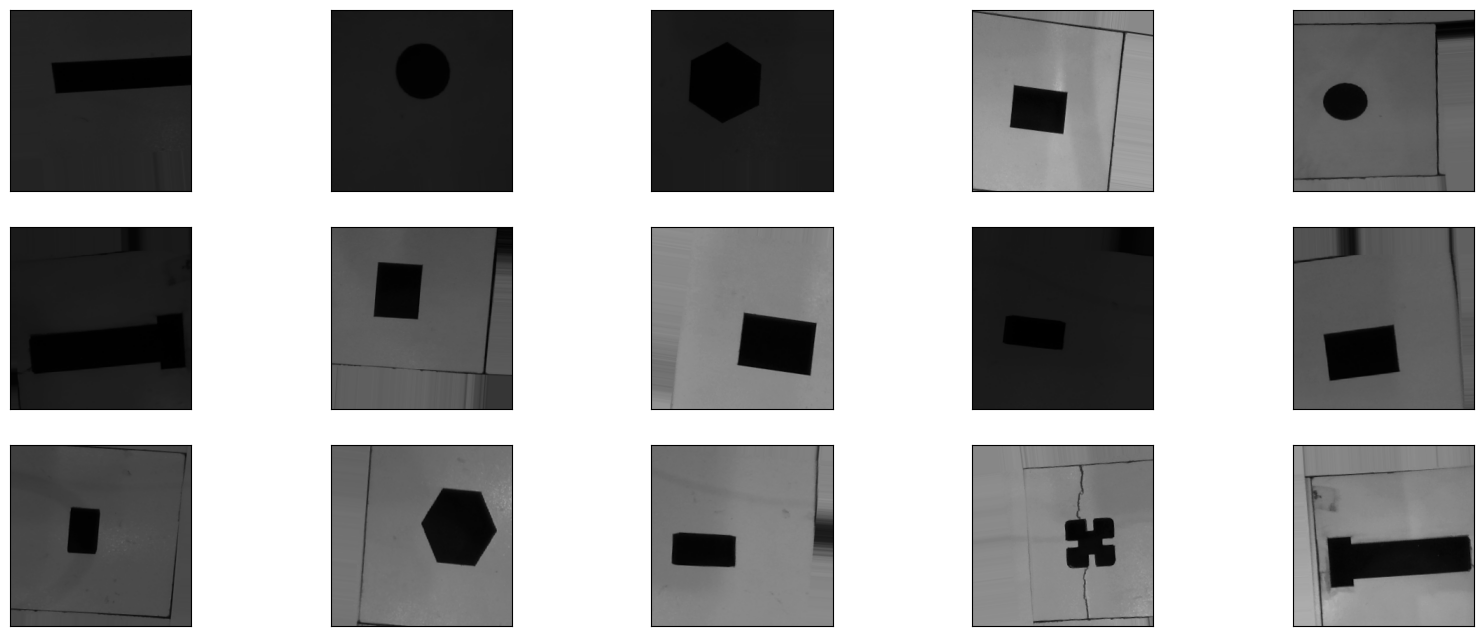

In [56]:
figure = plt.figure(figsize=(20, 8))
for i in range(15) :
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    image = next(train_generator)[0][-1].astype('uint8')
    #plt.title(class_names[labels[i]])

    ax.imshow(np.squeeze(image))
    

ReduceLROnPlateau = https://keras.io/api/callbacks/reduce_lr_on_plateau/ -> reduce lr when no improvment
EarlyStopping     = https://keras.io/api/callbacks/early_stopping/       -> stop training if no improvment
ModelCheckpoint   = https://keras.io/api/callbacks/model_checkpoint/     -> save checkpoint
TensorBoard       = https://keras.io/api/callbacks/tensorboard/          -> tensorboard

In [72]:
earlystop               = EarlyStopping(patience=10)
tensorboard             = TensorBoard(log_dir=tensorboard_log,histogram_freq=1,update_freq='batch',profile_batch=True ,write_graph=True,write_images=True,write_steps_per_second=True)
checkpoint              = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='max',save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
callbacks               = [earlystop, learning_rate_reduction,checkpoint,tensorboard]

ERROR:tensorflow:Failed to start profiler: Another profiler is running.


Build Model

In [2]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
import tensorflow as tf
def model_builder():
    inputs = layers.Input(shape=(Image_Width, Image_Height, Image_Channels))
    model = EfficientNetB2(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    #model.trainable = True
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(Num_Class, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss=loss_function, metrics=["accuracy","MeanSquaredError","AUC"]
    )
    return model
model = model_builder()

2023-04-16 14:08:49.515686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'Image_Width' is not defined

In [1]:
model.summary()

NameError: name 'model' is not defined

Start Training

In [ ]:

history = model.fit(
    train_generator,
    epochs=Epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // Batch_Size,
    steps_per_epoch=train_generator.samples // Batch_Size,
    callbacks=callbacks
)

Epoch 1/100
ERROR:tensorflow:Failed to start profiler: Another profiler is running.


2023-04-16 13:38:42.612412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-16 13:38:49.018111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  8/401 [..............................] - ETA: 2:46 - loss: 1.0260 - accuracy: 0.6781 - mean_squared_error: 0.0409 - auc: 0.9397

Save Models

In [7]:
now = datetime.now()
 
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print(model_save_path+'/'+dt_string+'.h5')
model.save(model_save_path+'/'+dt_string+'.h5')

./15-07-2022_10-04-39.h5


In [6]:
from keras.models import load_model
model = load_model('check_point_last.h5')

2022-07-15 10:04:35.670748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 10:04:35.711085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 10:04:35.712358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 10:04:35.714210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [26]:
test_path = "../datasets/storage_disk/h/labled_data/train"

Predict For check data

In [29]:
len(images_path)

399632

In [28]:
folders = os.listdir(test_path)
images_path = []
for folder in folders :
    for image in os.listdir(test_path+'/'+folder):
        path = test_path+'/'+folder+'/'+image
        images_path.append(path)
        

In [30]:
def image_predict(image_path):
    
    img = image_loader.load_img(image_path,target_size=(224,224))
    img_tensor = image_loader.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)   
    return img_tensor


In [31]:
random.shuffle(images_path)
labels =train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
print(labels)
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i,img_path in enumerate( images_path[0:15]):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    image = image_loader.load_img(img_path, target_size=Image_Size)
    ax.imshow(np.squeeze(image))
    image_to_predict = image_predict(img_path)
    predict = np.argmax(model.predict(image_to_predict))
    true_label = "porn" if '/p_' in img_path else "normal"
    ax.set_title("predict :{} ({})".format(labels[predict], 
                                  true_label),
                                  color=("green" if true_label == labels[predict] else "red"))

NameError: name 'train_generator' is not defined

In [ ]:
from keras.models import load_model
del model
model = load_model('25_03_2022.22_11_26.h5')

In [ ]:
y_pred = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])
y_test = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2])

In [35]:
labels = {
    0:'porn',
    1:'normal'
}
y_pred = []
y_test = []

labels = dict((v, k) for k, v in labels.items())
for folder in os.listdir("../datasets/storage_disk/h/labled_data/train"):
    items = os.listdir("../datasets/storage_disk/h/labled_data/train/"+folder)
    random.shuffle(items)
    counter = 0
    for item in items:
            image_to_predict = image_predict("../datasets/storage_disk/h/labled_data/train/"+folder+"/"+item)
            predict = np.argmax(model.predict(image_to_predict))
            real_id = 0 if folder=='normal' else 1
            y_pred.append(predict)
            y_test.append(real_id)


2022-07-15 10:09:02.393713: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 0s 16ms/step


KeyboardInterrupt: 

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()